# Exercises Week 7 : Linear regression, Gaussian distributions, and Gaussian Processes

### Learning objectives

The purpose of this exercise is to become familiar with the multivariate Gaussian distribution and the basics of Bayesian inference. After completing the exercise, you should be able to:

- Manipulate, implement, and sample from  multivariate Gaussian densities.
- Explain the role of the prior, likelihood, posterior, and model evidence in Bayesian inference.
- Derive the posterior distribution of the regression weight for a ridge regression model. 

You are only allowed to use the numpy module to solve the exercises and **not** statistics specific modules (e.g scipy.stats or GPy). Check the first two sections of the lecture slides first, and then complete the three tasks below. 

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb
snb.set(font_scale=1.5)

### Gaussian linear regression

Linear regression is perhaps the most frequently used technique in applied statistics for modelling the relationship between set of a predictor variables $\left\lbrace \mathbf{x}_i \right\rbrace_{i=1}^N$ and a response variable $\left\lbrace y_i \right\rbrace_{i=1}^N$. More formally, let $\mathbf{X} \in \mathbb{R}^{N \times D}$ be a design matrix and let  $\mathbf{y} \in \mathbb{R}^N$ be the response variables collected into a single vector, then the linear regression model is given by

\begin{align}
\mathbf{y} = \mathbf{X}\mathbf{w} + \mathbf{\epsilon},
\end{align}

where $\mathbf{w} \in \mathbb{R}^D$ is the regression weights and $\mathbf{\epsilon} \in \mathbb{R}^N$ is the observation noise vector.

Assuming isotropic Gaussian noise and imposing a multivariate Gaussian prior on $\mathbf{w} \sim \mathcal{N}\left(\mathbf{m}, \mathbf{S}\right)$ gives rise to the following joint distribution

\begin{align}
p(\mathbf{y}, \mathbf{w}) = p\left(\mathbf{y}|\mathbf{w}\right)p\left(\mathbf{w}\right) = \mathcal{N}\left(\mathbf{y}\big|\mathbf{Xw}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{w}\big|\mathbf{m}, \mathbf{S}\right).
\end{align}

In this exercise, we will use the following simple model as running example:

\begin{align}
y_i = ax_i + b +  \epsilon_i = \begin{bmatrix}x_i&1\end{bmatrix}\begin{bmatrix}a\\b\end{bmatrix} + \epsilon_i
\end{align}

That is, the parameters are $\mathbf{w} = \left[a, b\right]$, where $a$ and $b$ are the slope and intercept of the line, respectively. Furthermore, we will assume $\mathbf{m} = \mathbf{0}$, $\mathbf{S} = \mathbf{I}$, and $\sigma^2 = 2$.

We will use the following dataset with $N = 8$ data points

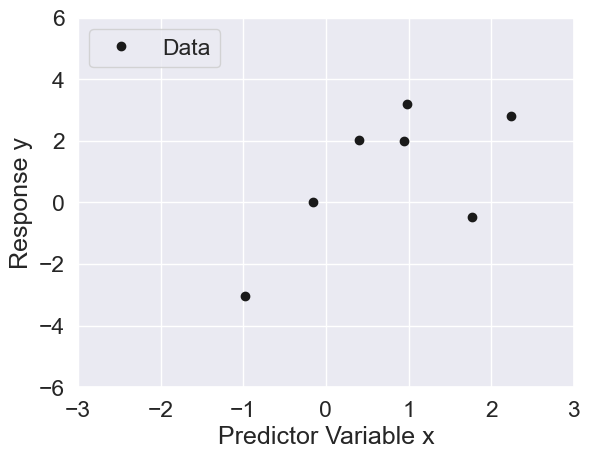

In [2]:
# hyperparameters of the prior
m = np.zeros((2, 1))
S = 1.0*np.identity(2)

# noise variance
sigma2 = 2

# data
N = 8
x = np.array([1.764, 0.4, 0.979, 2.241, 1.868, -0.977,  0.95, -0.151])[:, None]
y = np.array([-0.464, 2.024, 3.191, 2.812, 6.512, -3.022, 1.99, 0.009])[:, None]

# plot
plt.plot(x, y, 'k.', label='Data', markersize=12)
plt.xlabel('Predictor Variable x')
plt.ylabel('Response y')
plt.legend()
plt.xlim((-3, 3))
plt.ylim((-6, 6));

### Task 1: The prior, likelihood and posterior 

The purpose of this task is to implement the basic building blocks of the linear model. In the cells below, you are given a set of function templates and the task is to complete the implementations as specified below.

Hint: look for Rasmussen book section 2.1 (http://www.gaussianprocess.org/gpml/)

- **Task 1a**: Implement the multivariate Gaussian density function using `Numpy` (Hint: to avoid numerical problems, always add a small diagonal constant to covariance matrices)

\begin{align}
N(x | \mu, \Sigma ) = (2\pi)^{-\frac{D}{2}} | \Sigma |^{-\frac{1}{2}} \exp\left[-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu) \right]
\end{align}



In [3]:
def mvn_pdf(x, mu, Sigma, log=True):
    """ Returns the density of a multivariate Gaussian distribution
    with mean mu and covariace Sigma at point x
    
    Arguments:
    x     -- (Dx1) evaluation point
    mu    -- (Dx1) mean vector
    Sigma -- (DxD) covariance matrix
    log   -- (bool) if true, return log density. If false, return the density. (default=True)
      
    Returns:
    (scalar) density
    """

    ###############################################
    # ------- insert code here -------------------
    ###############################################
    
    # Model solution
    D = len(mu)
    Sigma = Sigma + 1e-10 * np.identity(D)
    L = np.linalg.cholesky(Sigma)
    v = np.linalg.solve(L, x-mu)
    const_term = -0.5 * D * np.log(2 * np.pi)
    det_term = -0.5 * 2 * np.sum(np.log(np.diag(L)))
    quad_term = -0.5 * np.sum(v **2)
    if log:
        return const_term + det_term + quad_term
    else:
        return np.exp(const_term + det_term + quad_term)

In [4]:
from scipy.stats import multivariate_normal

x_test = np.array([1,1])
print("Scipy multivariate_normal model answer")
pdf = multivariate_normal.pdf(x_test, mean=m.flatten(), cov=S)
print("The pdf of [1,1] is", pdf)
logpdf = multivariate_normal.logpdf(x_test, mean=m.flatten(), cov=S)
print("The logpdf of [1,1] is", logpdf)

x_test = np.array([1,1]).reshape(2,1)
print("\nOwn mvn_pdf answer")
pdf = mvn_pdf(x_test, mu=m, Sigma=S, log=False)
print("The pdf of [1,1] is", pdf)
logpdf = mvn_pdf(x_test, mu=m, Sigma=S, log=True)
print("The logpdf of [1,1] is", logpdf)

Scipy multivariate_normal model answer
The pdf of [1,1] is 0.05854983152431917
The logpdf of [1,1] is -2.8378770664093453

Own mvn_pdf answer
The pdf of [1,1] is 0.05854983152431917
The logpdf of [1,1] is -2.8378770664093453


- **Task 1b**: Implement functions to evaluate log density of the (i) prior, (ii) likelihood and (iii) posterior (likelihood times prior) using the <tt>mvn_pdf</tt> function above. Hint: Use the function <tt>predict(x,a,b)</tt> given below

In [5]:
def predict(x, a, b):
    """ returns prediction for inputs x given parameter (a,b)
    
    Arguments:
    x    --  (Nx1) vector of inputs
    a    --  slope parameter
    b    --  intercept parameter
    
    Returns:
    (Nx1) vector of predictions
    """
    return a*x + b


def log_prior(a, b, m, S):
    """ returns the log density of the prior at the points (a,b) given m and S
    
    Arguments:
    a    -- (scalar) slope parameter
    b    -- (scalar) intercept parameter
    m    -- (2x1) The prior mean
    S    -- (2x2) The prior covariance
    
    Returns
    (scalar) log density for the pair (a,b)
    
    """
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    #return mvn_pdf(np.array([a,b]).reshape(2,1), m, S, log=True)
    return mvn_pdf(np.array([a,b])[:, None], m, S, log=True)

def log_likelihood(x, y, a, b):
    """ returns the log-likelihood for the data (x,y) given the parameters (a,b)
    
    Arguments:
    x    -- (Nx1) vector of inputs
    y    -- (Nx1) vector of responses
    a    -- slope parameter
    b    -- intercept parameter
    
    Returns:
    (scalar) log likelihood of (x,y) 
    """
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    return np.sum(log_npdf(y, predict(x,a,b), sigma2))

log_npdf = lambda x, m, v: -0.5 * np.log(2* np.pi * v) - 0.5 * (x - m)**2/v

def log_posterior(x, y, a, b, m, S):
    """ returns the log posterior at (a,b), given the data (x,y) and the prior parameters (m, S)
    
    Arguments:
    x    -- (Nx1) vector of inputs
    y    -- (Nx1) vector of responses
    a    -- slope parameter
    b    -- intercept parameter
    m    -- (2x1) The prior mean
    S    -- (2x2) The prior covariance
    
    Returns:
    (scalar) log posterior of (x,y)
    """
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    
    # mu = np.array([a,b]).reshape(2,1)
    # A = (1/sigma2 * x.T @ x).item() + np.linalg.inv(S)
    # mu_pred = np.linalg.inv(A) @ (1/sigma2 * (x.T @ y).item() + np.linalg.inv(S) @ m)
    # log_posterior = mvn_pdf(mu, mu_pred, np.linalg.inv(A), log=True)

    log_posterior = log_prior(a,b,m,S) + log_likelihood(x,y,a,b)
    return log_posterior

- **Task 1c**: The goal of this task is to make contour plots of the prior density, the likelihood and the posterior as a function of (a,b) in the intervals $-6 \leq a \leq 6$ and $-6 \leq b \leq 6$, respectively, by completing the implementation of the functions: <tt>plot_prior_density</tt>,  <tt>plot_likelihood</tt>,  <tt>plot_posterior_density</tt> given below. 

Hint: Check the `Numpy` function `meshgrid` and pyplot function `contour` to plot 2D densities.

Hint: You are trying to reproduce the visualisations of page 61 of Slides SW07.


Text(0.5, 1.0, 'Posterior')

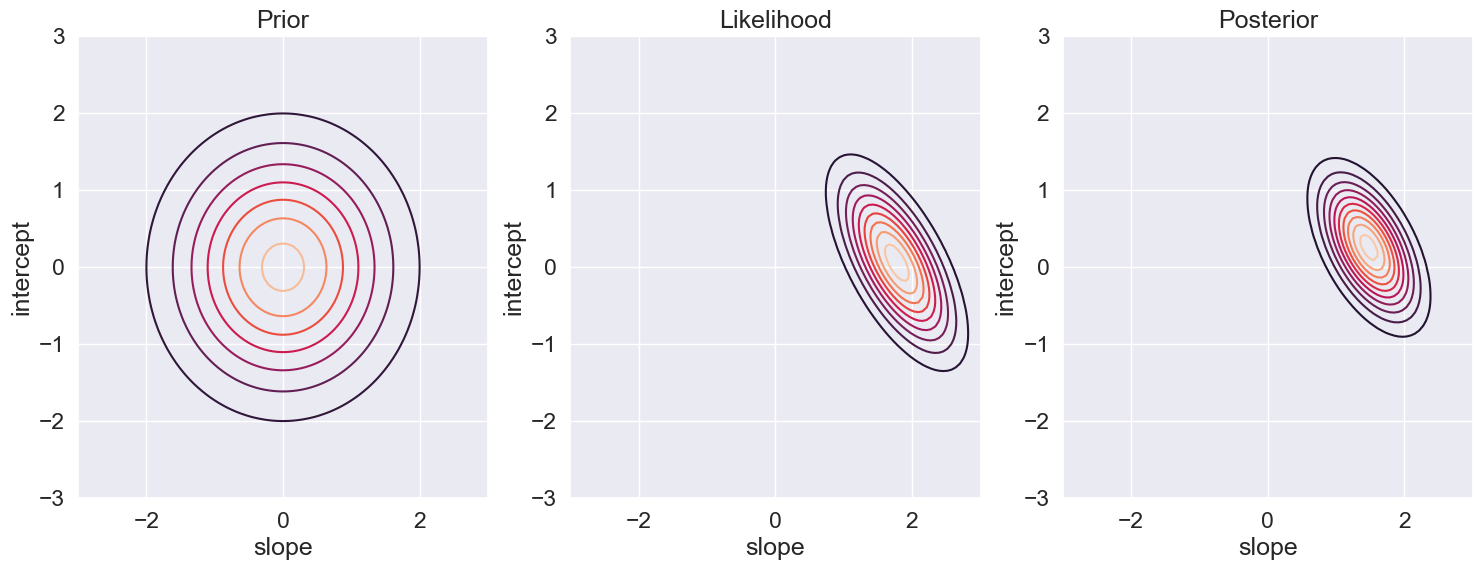

In [6]:
a_array = np.linspace(-3,3,100)
b_array = np.linspace(-3,3,100)

def log_to_density(Z):
    Z = Z - np.max(Z)
    Z = np.exp(Z)
    return Z/np.sum(Z)

def plot_prior_density(m, S):
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    
    A_array, B_array = np.meshgrid(a_array, b_array)
    Z = np.array([log_prior(ai, bi, m, S) for (ai, bi) in zip(A_array.ravel(), B_array.ravel())])
    Z = Z.reshape((len(a_array), len(b_array)))
    plt.contour(a_array, b_array, log_to_density(Z))
    plt.xlabel('slope')
    plt.ylabel('intercept');

def plot_likelihood(x, y):
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    
    A_array, B_array = np.meshgrid(a_array, b_array)
    Z = np.array([log_likelihood(x, y, ai, bi) for (ai, bi) in zip(A_array.ravel(), B_array.ravel())])
    Z = Z.reshape((len(a_array), len(b_array)))
    plt.contour(a_array, b_array, log_to_density(Z), 10)
    plt.xlabel('slope')
    plt.ylabel('intercept');

def plot_posterior_density(x, y, m, S):
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    
    A_array, B_array = np.meshgrid(a_array, b_array)
    Z = np.array([log_posterior(x, y, ai, bi, m, S) for (ai, bi) in zip(A_array.ravel(), B_array.ravel())])
    Z = Z.reshape((len(a_array), len(b_array)))
    plt.contour(a_array, b_array, log_to_density(Z), 10)
    plt.xlabel('slope')
    plt.ylabel('intercept');

# plot
plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
plot_prior_density(m, S)
plt.title('Prior')

plt.subplot(1, 3, 2)
plot_likelihood(x, y)
plt.title('Likelihood')

plt.subplot(1, 3, 3)
plot_posterior_density(x, y, m, S)
plt.title('Posterior')

### Task 2: Analytical expression of the posterior distribution

- **Task 2a**: Show that the posterior is given by $p(\mathbf{w}\big|\mathbf{y}) = \mathcal{N}\left(\mathbf{w}\big|\mu, \Sigma\right)$, where


\begin{align}
\Sigma &= \left(\frac{1}{\sigma^2}\mathbf{X}^T\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}\\
\mu &= \Sigma\left(\frac{1}{\sigma^2}\mathbf{X}^T\mathbf{y} + \mathbf{S}^{-1}\mathbf{m}\right)
\end{align}

Hints:
1. Use Bayes rule to obtain an expression for the posterior $p(\mathbf{w}\big|\mathbf{y})$ in terms of the prior, likehood and marginal likelihood
2. Take the logarithm on both sides and expand the right hand side
3. Conclude that only a subset of the terms depends on $\mathbf{w}$. Replace all terms independent of $\mathbf{w}$ with a constant
4. Argue that the posterior distribution must be Gaussian as the remaining terms on the right hand side is a quadratic function of $\mathbf{w}$. 
5. Determine the posterior mean and covariance by 'completing the square' or by comparing the coefficients of the quadratic functions to the logarithm of a multivariate Guassian distribution with mean $\mu$ and covariance $\Sigma$.

For background see Rasmussen section 2.1.1.

***Write your derivation here *** 


# Step 1:

Initial, we have the following information about the prior and the likelihood


Prior: $p(\mathbf{w}) \sim \mathcal{N}(\mathbf{w} | \mathbf{m}, \mathbf{S})$

Likelihood: $p(\mathbf{y}|\mathbf{w}) \sim \mathcal{N}(\mathbf{y} | \mathbf{X}\mathbf{w}, \sigma^2 \mathbf{I})$ (Proof for likelihood already provided in lecture notes)

To calculate the posterior, we can use Bayes' theorem:

\begin{align}
p(\mathbf{w}|\mathbf{y}) = \frac{p(\mathbf{y}|\mathbf{w}) p(\mathbf{w})}{p(\mathbf{y})} = \dfrac{\mathcal{N}(\mathbf{y} | \mathbf{X}\mathbf{w}, \sigma^2 \mathbf{I}) \mathcal{N}(\mathbf{w} | \mathbf{m}, \mathbf{S})}{p(\mathbf{y})}
\end{align}


$=> 
p(\mathbf{w}|\mathbf{y}) = p(\mathbf{y})^{-1}
    \dfrac{1}{\sqrt{(2\pi)^k|\boldsymbol{\sigma^2 \mathbf{I}}|}} 
    \exp\left(-\dfrac{1}{2}(\mathbf{y}-\mathbf{X}\mathbf{w})^T
    \boldsymbol{(\sigma^2 \mathbf{I}})^{-1}(\mathbf{y}-\mathbf{X}\mathbf{w})\right)
    \dfrac{1}{\sqrt{(2\pi)^k|\boldsymbol{S}|}} 
    \exp\left(-\dfrac{1}{2}(\mathbf{w}-\boldsymbol{m})^T
    \boldsymbol{S}^{-1}(\mathbf{w}-\boldsymbol{m})\right)
$

# Step 2: 
The posterior only depends on the terms containing $\mathbf{w}$. All constant terms can be discarded from the derivation 

$=> 
p(\mathbf{w}|\mathbf{y}) =
    \exp\left(-\dfrac{1}{2}(\mathbf{y}-\mathbf{X}\mathbf{w})^T
    \boldsymbol{(\sigma^2 \mathbf{I}})^{-1}(\mathbf{y}-\mathbf{X}\mathbf{w})\right)
    \exp\left(-\dfrac{1}{2}(\mathbf{w}-\boldsymbol{m})^T
    \boldsymbol{S}^{-1}(\mathbf{w}-\boldsymbol{m})\right) + C
$

# Step 3:

Taking the logarithms on both sides and expand the right side

$p(\mathbf{w}|\mathbf{y}) =
    \exp\left(-\dfrac{1}{2}(\mathbf{y}-\mathbf{X}\mathbf{w})^T
    \boldsymbol{(\sigma^2 \mathbf{I}})^{-1}(\mathbf{y}-\mathbf{X}\mathbf{w})\right)
    \exp\left(-\dfrac{1}{2}(\mathbf{w}-\boldsymbol{m})^T
    \boldsymbol{S}^{-1}(\mathbf{w}-\boldsymbol{m})\right) + C
$

$=>
\log p(\mathbf{w}|\mathbf{y}) =
    \log\left(
        \exp\left(-\dfrac{1}{2}(\mathbf{y}-\mathbf{X}\mathbf{w})^T
    \boldsymbol{(\sigma^2 \mathbf{I}})^{-1}(\mathbf{y}-\mathbf{X}\mathbf{w})\right)
    \exp\left(-\dfrac{1}{2}(\mathbf{w}-\boldsymbol{m})^T
    \boldsymbol{S}^{-1}(\mathbf{w}-\boldsymbol{m})\right)
    \right) + C
$

$=> 
log p(\mathbf{w}|\mathbf{y}) =
    \left(-\dfrac{1}{2}(\mathbf{y}-\mathbf{X}\mathbf{w})^T
    \boldsymbol{(\sigma^2 \mathbf{I}})^{-1}(\mathbf{y}-\mathbf{X}\mathbf{w})
    -\dfrac{1}{2}(\mathbf{w}-\boldsymbol{m})^T
    \boldsymbol{S}^{-1}(\mathbf{w}-\boldsymbol{m})\right) + C
$

$=> 
log p(\mathbf{w}|\mathbf{y}) =
    \left(-\dfrac{1}{2}\boldsymbol{(\sigma^2 \mathbf{I}})^{-1}(\mathbf{y}-\mathbf{X}\mathbf{w})^T
    (\mathbf{y}-\mathbf{X}\mathbf{w})
    -\dfrac{1}{2}\boldsymbol{S}^{-1}(\mathbf{w}-\boldsymbol{m})^T
    (\mathbf{w}-\boldsymbol{m})\right) + C
$

We need to expand the identity $(\textbf{y}-\textbf{X}\textbf{w})^T(\textbf{y}-\textbf{X}\textbf{w})$:

$(\textbf{y}-\textbf{X}\textbf{w})^T(\textbf{y}-\textbf{X}\textbf{w}) = \textbf{y}^T\textbf{y} - \textbf{y}^T\textbf{X}\textbf{w}-\textbf{w}^T\textbf{X}^T\textbf{y}+\textbf{w}^T\textbf{X}^T\textbf{X}\textbf{w} = 
\textbf{y}^T\textbf{y} - 2\textbf{X}^T\textbf{y}\textbf{w}+\textbf{w}^T\textbf{X}^T\textbf{X}\textbf{w} 
$ 

The term $\textbf{y}^T\textbf{y}$ can be dropped as it is constant with respect to  $\textbf{w}$

Also, we can expand the identity $(\textbf{m}-\textbf{w})^T(\textbf{m}-\textbf{w})$:

$(\textbf{m}-\textbf{w})^T(\textbf{m}-\textbf{w}) = \textbf{w}^{T}\textbf{w} - \textbf{w}^{T}\textbf{m} - \textbf{m}^{T}\textbf{w} + \textbf{m}^{T}\textbf{m} =  \textbf{w}^{T}\textbf{w} - 2\textbf{m}^{T}\textbf{w} + \textbf{m}^{T}\textbf{m}
$ 

The term $\textbf{m}^{T}\textbf{m}$ can be dropped as it is constant with respect to $\textbf{w}$


$=> 
log p(\mathbf{w}|\mathbf{y}) =
    \left(-\dfrac{1}{2}\boldsymbol{(\sigma^2 \mathbf{I}})^{-1}(- 2\textbf{X}^T\textbf{y}\textbf{w}+\textbf{w}^T\textbf{X}^T\textbf{X}\textbf{w})
    -\dfrac{1}{2}\boldsymbol{S}^{-1}(\textbf{w}^{T}\textbf{w} - 2\textbf{m}^{T}\textbf{w})\right) + C
$

$=> 
log p(\mathbf{w}|\mathbf{y}) =
    \left(-\dfrac{1}{2}\dfrac{1}{\boldsymbol{\sigma^2}}(- 2\textbf{X}^T\textbf{y}\textbf{w}+\textbf{w}^T\textbf{X}^T\textbf{X}\textbf{w})
    -\dfrac{1}{2}\boldsymbol{S}^{-1}(\textbf{w}^{T}\textbf{w} - 2\textbf{m}^{T}\textbf{w})\right) + C
$

$=> 
log p(\mathbf{w}|\mathbf{y}) =
    \left(
    \dfrac{1}{\boldsymbol{\sigma^2}}\textbf{X}^T\textbf{y}\textbf{w}
    -\dfrac{1}{2}\textbf{w}^T\dfrac{1}{\boldsymbol{\sigma^2}}\textbf{X}^T\textbf{X}\textbf{w}
    -\dfrac{1}{2}\textbf{w}^{T}\boldsymbol{S}^{-1}\textbf{w}
    + \boldsymbol{S}^{-1}\textbf{m}^{T}\textbf{w}
    \right) + C
$

$=> 
log p(\mathbf{w}|\mathbf{y}) =
    \left(
    -\dfrac{1}{2}\textbf{w}^T(\dfrac{1}{\boldsymbol{\sigma^2}}\textbf{X}^T\textbf{X} + \boldsymbol{S}^{-1})\textbf{w} 
    + (\dfrac{1}{\boldsymbol{\sigma^2}}\textbf{X}^T\textbf{y} + \boldsymbol{S}^{-1}\textbf{m}^{T})\textbf{w}
    \right) + C
$

# Step 4:

The posterior is also a Normal distribution, because the right hand side in the formula is with quadratic respect to $\textbf{w}$, where

$=> 
log p(\mathbf{w}|\mathbf{y}) \propto
    \left(
    -\dfrac{1}{2}\textbf{w}^T\boldsymbol{A}\textbf{w} 
    + \boldsymbol{b}\textbf{w}
    \right)
$
where $A = \dfrac{1}{\boldsymbol{\sigma^2}}\textbf{X}^T\textbf{X} + \boldsymbol{S}^{-1}$ and $b = (\dfrac{1}{\boldsymbol{\sigma^2}}\textbf{X}^T\textbf{y} + \boldsymbol{S}^{-1}\textbf{m})$ 

# Step 5:

Completing the square claim: This requires A to be symmetric

$$ \dfrac{1}{2}x^TAx-b^Tx = \dfrac{1}{2}(x-A^{-1}b)^TA(x-A^{-1}b)-\dfrac{1}{2}b^TA^{-1}b$$

where the Gaussian distribution is constructed as $\mathcal{N}(x|A^{-1}b, A^{-1})$, because the term $-\dfrac{1}{2}b^TA^{-1}b$ is constant with respect to $x$

$=> 
\log p(\mathbf{w}|\mathbf{y}) \propto
    \mathcal{N}(x|A^{-1}b, A^{-1})
$
where $A = \dfrac{1}{\boldsymbol{\sigma^2}}\textbf{X}^T\textbf{X} + \boldsymbol{S}^{-1}$ and $b = (\dfrac{1}{\boldsymbol{\sigma^2}}\textbf{X}^T\textbf{y} + \boldsymbol{S}^{-1}\textbf{m})$. In other words, the posterior follows a normal distribution, $\mathcal{N}(x|\boldsymbol{\mu}, \boldsymbol{\Sigma})$ with the parameter values as

\begin{align}
\Sigma &= \left(\frac{1}{\sigma^2}\mathbf{X}^T\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}\\
\mu &= \Sigma\left(\frac{1}{\sigma^2}\mathbf{X}^T\mathbf{y} + \mathbf{S}^{-1}\mathbf{m}\right)
\end{align}

This completes the proof for this exercise

- **Task 2b**: Complete the implementation of the function for computing the analytical posterior distribution given below. Hint: The function `design_matrix` maps from a vectors of input $\mathbf{x}$ to the design matrix $\mathbf{X}$.

In [7]:
def design_matrix(x):
    """ returns the design matrix for a vector of input values x 
    
    Arguments:
    x    -- (Nx1) vector of inputs
    
    Returns:
    (Nx2) design matrix
    
    """
    X = np.column_stack((x, np.ones(len(x))))
    return X

def compute_posterior(x, y, m, S, sigma2):
    """ return the posterior mean and covariance of w given (x,y) 
    and hyperparameters m, S and sigma2
    
    Arguments:
    x      -- (Nx1) vector of inputs
    y      -- (Nx1) vector of responses
    m      -- (Dx1) prior mean
    S      -- (DxD) prior covariance
    sigma2 -- (scalar) noise variance
    
    Returns:
    mu     -- (Dx1) posterior mean
    Sigma  -- (DxD) posterior covariance
    
    """
    import scipy as sc
    Sinv = np.linalg.inv(S)
    X = design_matrix(x)
    Sigmainv = Sinv + np.dot(X.T, X)/sigma2
    L = sc.linalg.cho_factor(Sigmainv)
    scaled_mu = np.dot(X.T, y)/sigma2 + np.linalg.solve(S,m)
    mu = sc.linalg.cho_solve(L, scaled_mu)
    Sigma = sc.linalg.cho_solve(L, np.identity(len(m)))
    
    #mu = np.array([a,b]).reshape(2,1)
    # Sigma = (1/sigma2 * x.T @ x).item() + np.linalg.inv(S)
    # mu = np.linalg.inv(Sigma) @ (1/sigma2 * (x.T @ y).item() + np.linalg.inv(S) @ m)
    #log_posterior = mvn_pdf(mu, mu_pred, np.linalg.inv(A), log=True)
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    
    return mu, Sigma
    

- **Task 2c**: Using the function above, compute the posterior mean and covariance for the data set $(\mathbf{x}, \mathbf{y})$. Plot the resulting density and check that it matches the posterior distribution from task 1d.

Hint: You should obtain a normalized version of the posterior visualisation of Task 1.

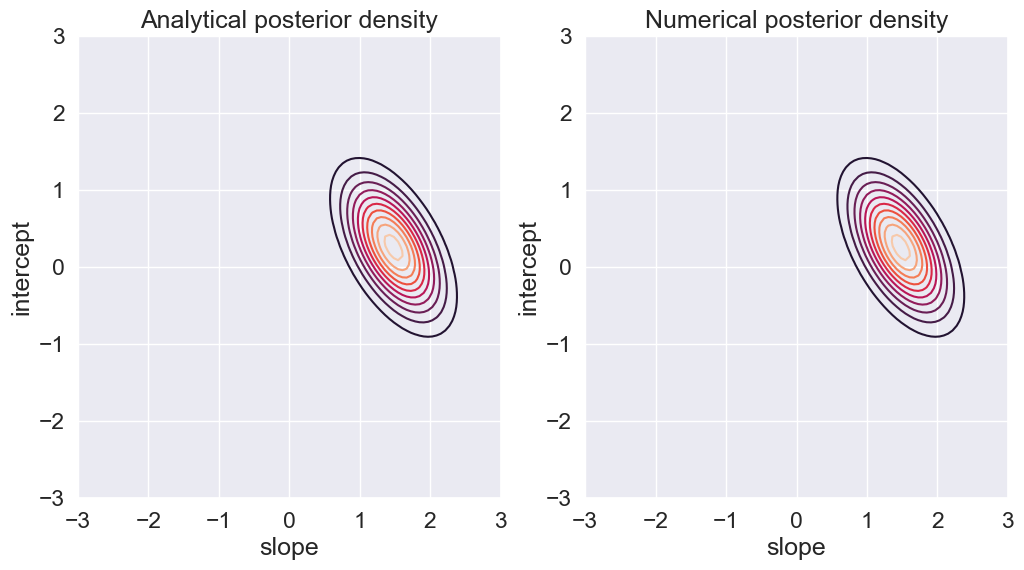

In [8]:
###############################################
# ------- insert code here -------------------
###############################################

mu, Sigma = compute_posterior(x, y, m, S, sigma2)
    
A_array, B_array = np.meshgrid(a_array, b_array)
AB = np.column_stack((A_array.ravel(), B_array.ravel()))
from scipy.stats import multivariate_normal as mvn
vals = np.array([mvn.logpdf(ab, mu.ravel(), Sigma) for ab in AB]).reshape((len(a_array), len(b_array)))

# plot
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.contour(a_array, b_array, log_to_density(vals), 10)
plt.title('Analytical posterior density')
plt.xlabel('slope')
plt.ylabel('intercept');

plt.subplot(1, 2, 2)
plot_posterior_density(x,y,m,S)
plt.title('Numerical posterior density')
plt.xlabel('slope')
plt.ylabel('intercept');

### Task 3: Combining all of the above

In this task, you will use all the functions you implemented above to compute the posterior distribution $p\left(\mathbf{w}|\mathbf{y}\right)$ for various sizes of $N$. The cell below analyses the data set using $N = \left\lbrace 1, 2, 10, 20 \right\rbrace$ data points, where the columns visualise (i) data and sample functions, (ii) the prior, (iii) the likelihood and (iv) posterior. 

- **Task 3a**: The code below is 100% complete, and works without issues if you have implemented all previous functions/tasks. You should see 4 visualisations.

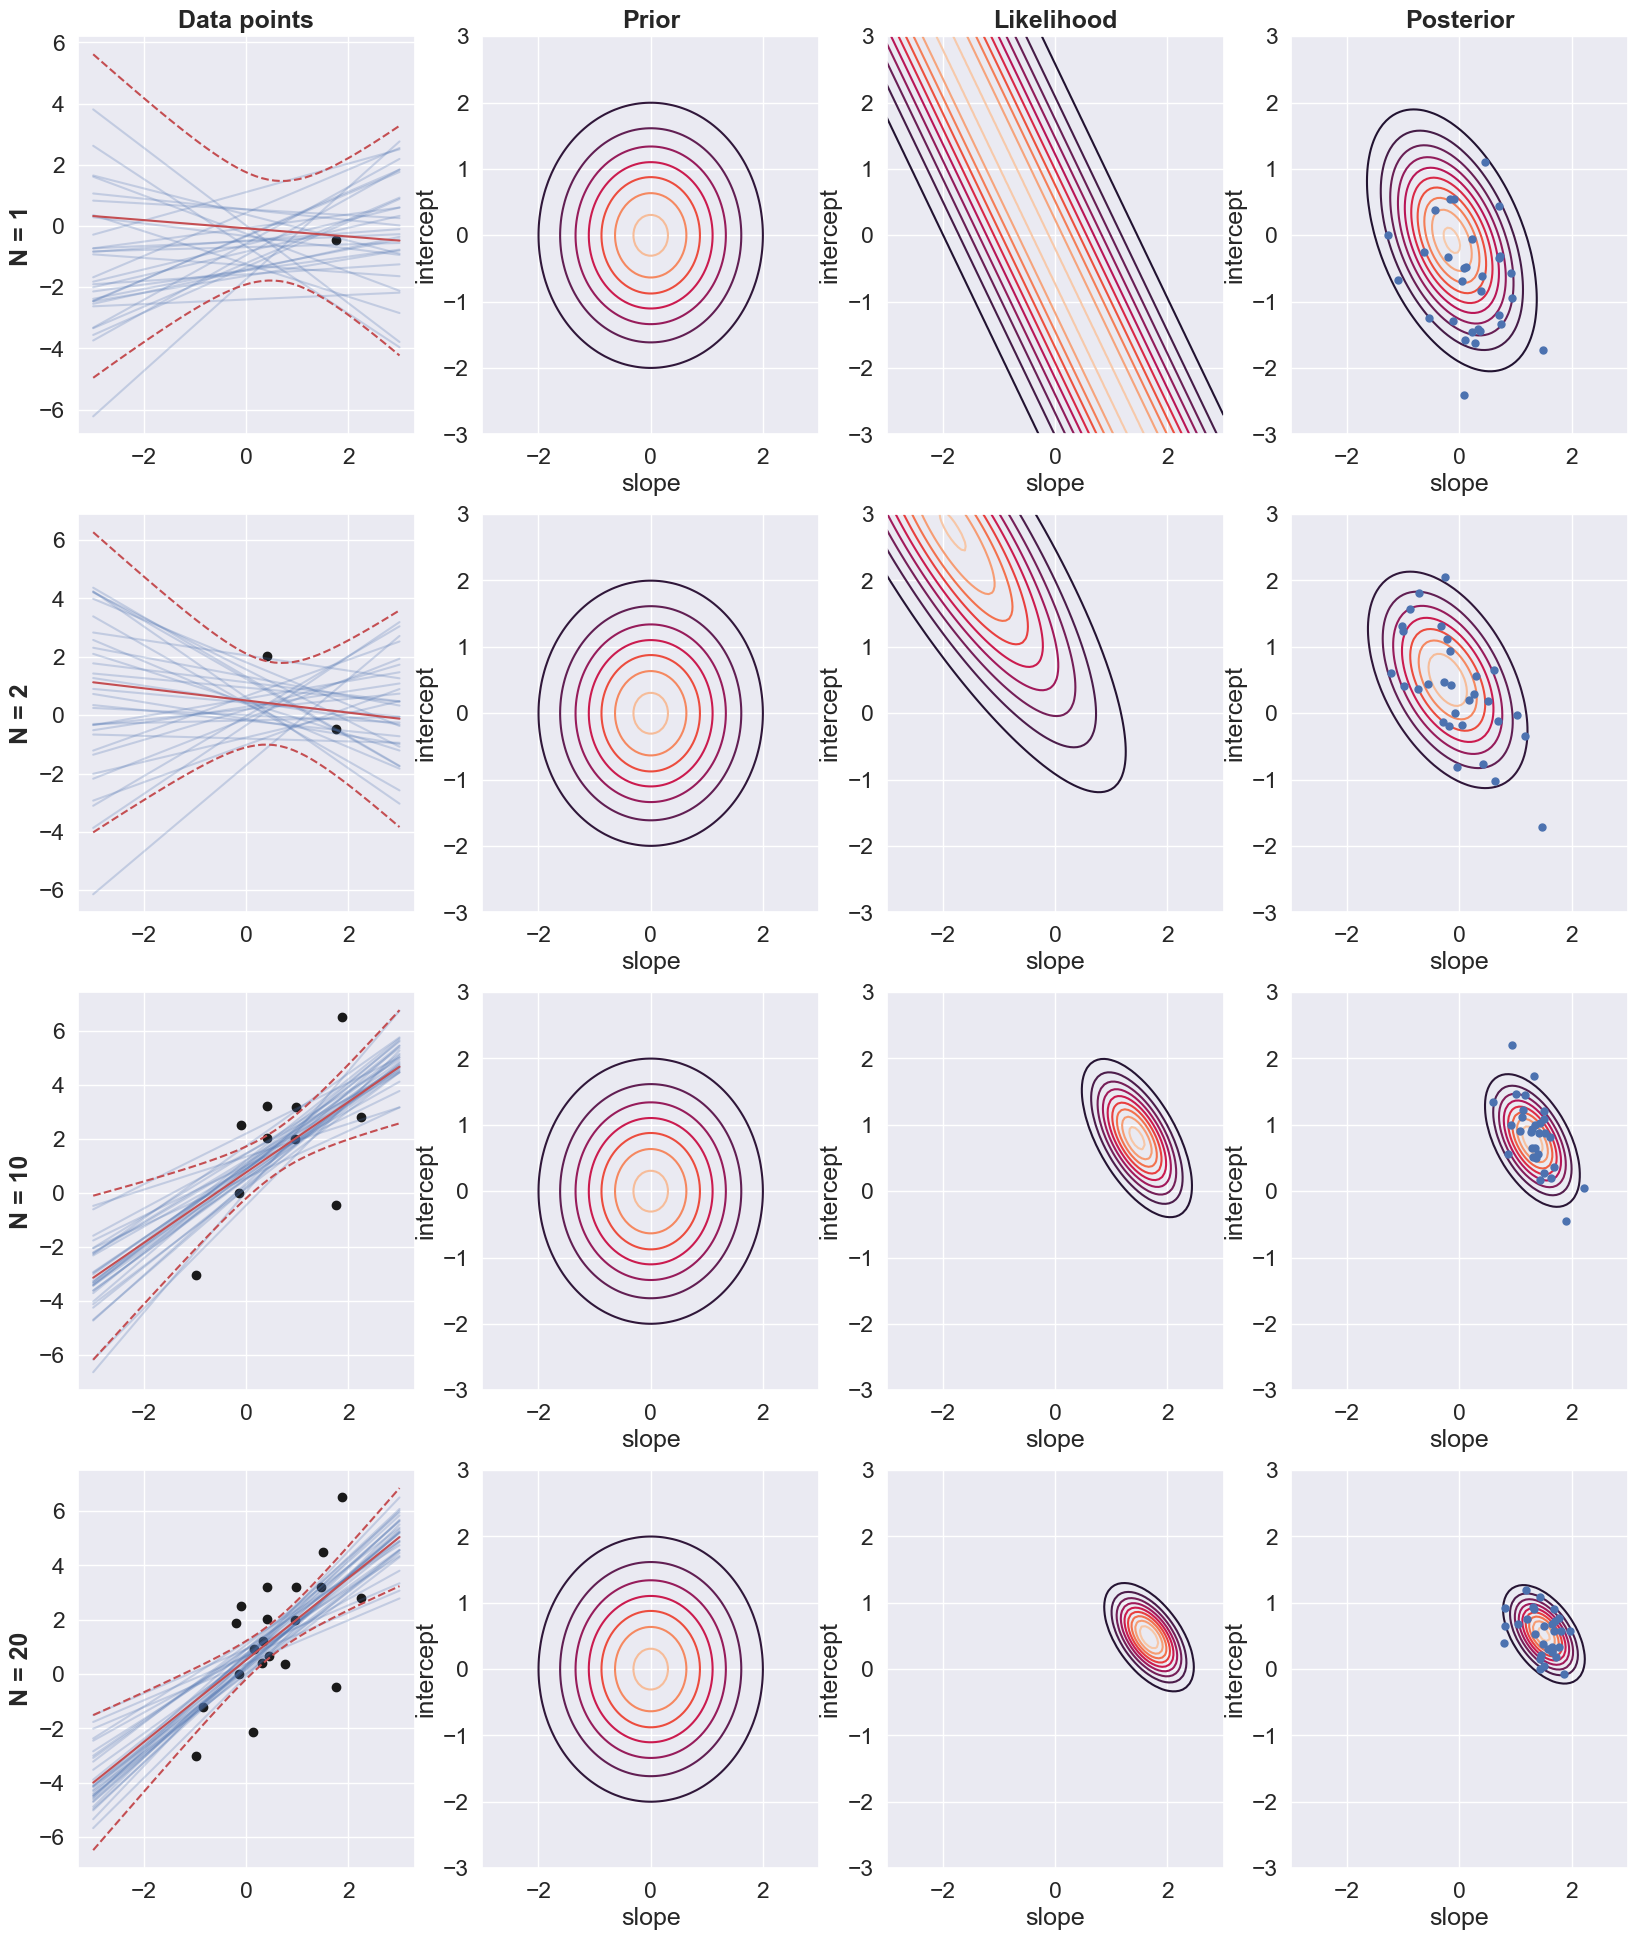

In [9]:
def generate_mvn_samples(mu, Sigma, M):
    """ return samples from a multivariate normal distribution N(mu, Sigma)

    Arguments:
    mu      -- (Dx1) mean vector
    Sigma   -- (DxD) covariance matrix
    M       -- (scalar) number of samples
    
    Returns:
    (DxM) matrix, where each column corresponds to a sample
    """
    
    jitter = 1e-8
    D = len(mu)
    L = np.linalg.cholesky(Sigma + jitter*np.identity(D))
    zs = np.random.normal(0, 1, size=(D, M))
    fs = mu + np.dot(L, zs)
    return fs

def compute_f_posterior(x, mu, Sigma):
    """ compute the posterior distribution of f(x) wrt. posterior distribution N(mu, Sigma) 
    
    Arguments:
    x      -- (Nx1) vector of inputs
    mu     -- (2x1) mean vector
    Sigma  -- (2x2) covariance matrix
    
    Returns:
    mu_f   -- (Nx1) vector of pointwise posterior means at x
    var_f  -- (Nx1) vector of pointwise posterior variances at x
    
    """
    
    X = np.column_stack((x, np.ones(len(x))))
    mu_f = np.dot(X, mu)
    var_f = np.diag(np.dot(np.dot(X, Sigma), X.T))[:, None]
        
    return mu_f, var_f


np.random.seed(21340)

# New data set with more data points
N_2 = 20
x_2 = np.array([1.764, 0.4, 0.979, 2.241, 1.868, -0.977,  0.95, -0.151, -0.103, 0.411, 0.144, 1.454, 0.761, 0.122,
              0.444, 0.334, 1.494, -0.205,  0.313, -0.854])[:, None]
y_2 = np.array([-0.464, 2.024, 3.191, 2.812, 6.512, -3.022, 1.99, 0.009, 2.513, 3.194, 0.935, 3.216, 0.386, -2.118,
               0.674, 1.222, 4.481, 1.893, 0.422, -1.209])[:, None]

xp = np.linspace(-3, 3, 50)[:, None]

plt.figure(figsize=(20, 30))    
for idx_n, n in enumerate([1, 2, 10, 20]):
    
    # compute posterior & generate samples
    mu, Sigma = compute_posterior(x_2[:n, :], y_2[:n, :], m, S, sigma2)
    ahat, bhat = generate_mvn_samples(mu, Sigma, M=30)
  
    # plot
    plt.subplot2grid((5, 4), (idx_n, 0))
    plt.plot(x_2[:n, :], y_2[:n, :], 'k.', markersize=12)
    plt.ylabel('N = %d' % n, fontweight='bold')    
    for (ai, bi) in zip(ahat, bhat):
        plt.plot(xp, predict(xp, ai, bi), 'b-', alpha=0.25)
        
    mu_f, var_f = compute_f_posterior(xp, mu, Sigma)
    std_f = np.sqrt(var_f)

    plt.plot(xp, mu_f, 'r')
    plt.plot(xp, mu_f + 2*std_f, 'r--')
    plt.plot(xp, mu_f - 2*std_f, 'r--')
    
    if idx_n == 0:
        plt.title('Data points', fontweight='bold')
        
    plt.subplot2grid((5, 4), (idx_n, 1))
    plot_prior_density(m, S)
    
    if idx_n == 0:
        plt.title('Prior', fontweight='bold')

    plt.subplot2grid((5, 4), (idx_n, 2))
    plot_likelihood(x_2[:n, :], y_2[:n, :])
       
    if idx_n == 0:
        plt.title('Likelihood', fontweight='bold')
    
    plt.subplot2grid((5, 4), (idx_n, 3))
    plot_posterior_density(x_2[:n, :], y_2[:n, :], m, S)
    plt.plot(ahat, bhat, 'b.', markersize=10)
    
    if idx_n == 0:
        plt.title('Posterior', fontweight='bold')


- **Task 3b**: Study the code and plots and explain what you see.

1. How does the blue lines in the first column relate to the blue dots in the fourth column? 
  
Each blue line in the first column is a straight line in the form of linear regression: $y = slope * x + intercept$, whose parameters slope and intercept correspond to one blue point in the fourth column, which is a pair of slope and coefficient in the posterior contour.  

   2. What happens as the number of samples increase?

Prior contours stay the same as the number of samples increases.

Likelihood contours become dramatically narrower as the number of samples increase

Posterior contours becomes smaller like likelihood contours, but not so significant as the number of samples increases.

Posterior draws: the range of the posterior draws becomes narrower, which tries to fit the data as much as possible as the number of samples increases. 

The reason for this behavior is the following: more data points imply more information, which helps reduce uncertainty in regression and makes likelihood and posterior draws narrower

   3. Why does the prior have so little effect in the last row?

The amount of data overwhelms the prior: in the last case, the amount of data available is large enough such that the likelihood completely overwhelms the prior, making the prior effect negligible in posterior draws.

Prior is not informative: If the prior is not informative, i.e., it does not provide much useful information about the distribution of the parameters, then it is unlikely to have a significant effect on the posterior. This is true in this case as the prior has zero mean and variance of one, which provideds little prior knowledge about the underlying data structure when there are many datapoints already.